# **Детекция дыма лесных пожаров на снимках с камер наружного наблюдения**

In [ ]:
import os
import math
import json
import zipfile

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import AnchorGenerator

from PIL import Image, ImageDraw, UnidentifiedImageError
from matplotlib import pyplot as plt

from google.colab import files, drive

from tqdm import tqdm

## Загрузка данных

In [ ]:
drive.mount('/content/gdrive')
with zipfile.ZipFile('/content/gdrive/MyDrive/Data/Wildfire_Smoke_Detection.v2.coco.zip', 'r') as f:
    f.extractall('.')

Mounted at /content/gdrive


In [ ]:
train_annotations = json.load(open('train/_annotations.coco.json'))
valid_annotations = json.load(open('valid/_annotations.coco.json'))
test_annotations = json.load(open('test/_annotations.coco.json'))
print(train_annotations.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


## Просмотр разметки

Класс для работы с аннотациями

In [ ]:
class CocoAnnotationCollector:

  def __init__(self, annotations):
    self.id2image = {}
    self.image2info = {}
    self.id2annotations = {}
    self.image_names = []
    self.annotations = annotations

    for info in self.annotations['images']:
      image_name = info['file_name']
      image_id = info['id']

      self.image_names.append(image_name)

      if image_id not in self.id2image:
        self.id2image[image_id] = image_name
        self.image2info[image_name] = {
            'id': image_id,
            'height': info['height'],
            'width': info['width']
        }

    for annot in self.annotations['annotations']:
      image_id = annot['image_id']

      if image_id not in self.id2annotations:
        self.id2annotations[image_id] = [{
            'area': annot['area'],
            'iscrowd': annot['iscrowd'],
            'bbox': annot['bbox']
        }]
      else:
        self.id2annotations[image_id].append({
            'area': annot['area'],
            'iscrowd': annot['iscrowd'],
            'bbox': annot['bbox']
        })
  def get_by_index(self, index):
      image_name = self.image_names[index]
      image_id = self.image2info[image_name]['id']
      return self.id2annotations[image_id]

  def get_by_name(self, name):
    image_id = self.image2info[name]['id']
    return self.id2annotations[image_id]

Сетка

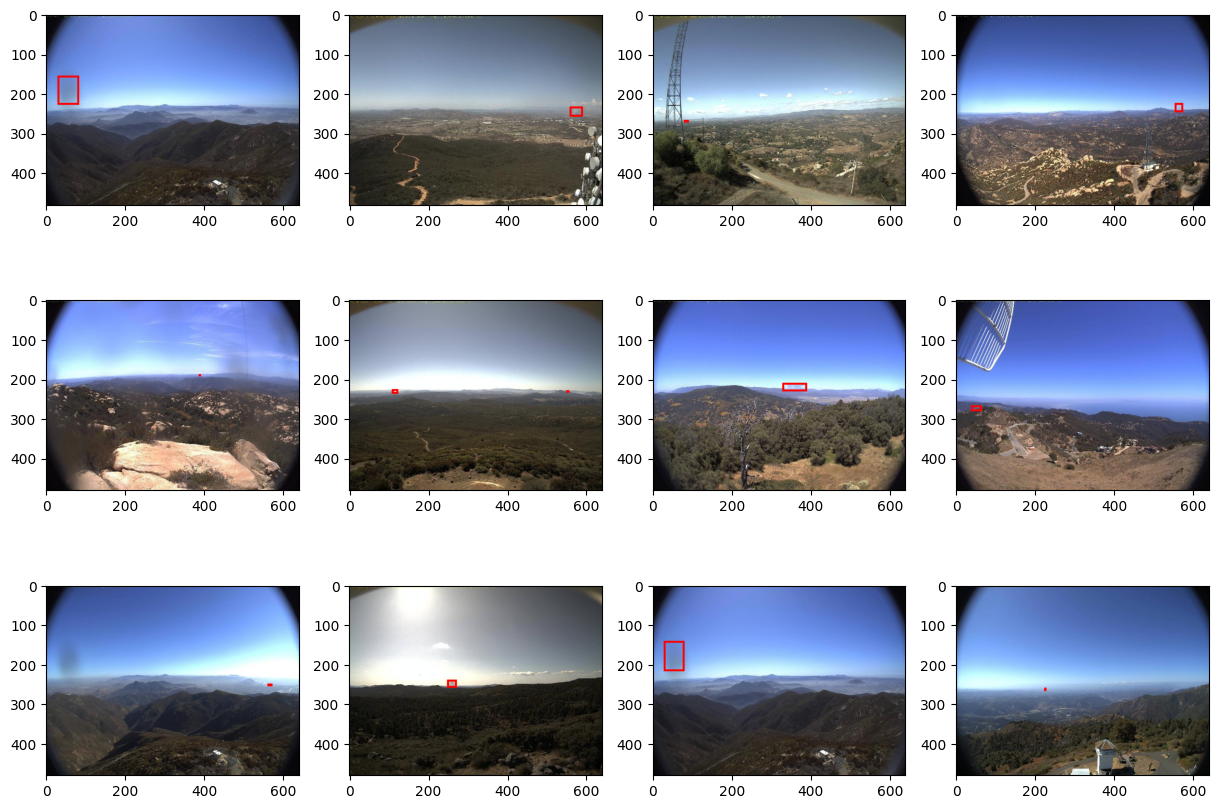

In [ ]:
N_IMAGES = 12
N_COLUMNS = 4
N_ROWS = math.ceil(N_IMAGES / N_COLUMNS)

annot_collector = CocoAnnotationCollector(train_annotations)

fig, axes = plt.subplots(N_ROWS, N_COLUMNS, figsize=(15, 3.5 * N_ROWS))

for pos, filename in enumerate(os.listdir('train')[:N_IMAGES]):
  if filename.endswith('.jpg'):
    image = Image.open(f'train/{filename}')
    draw = ImageDraw.Draw(image)

    image_annotations = annot_collector.get_by_name(filename)

    for annotation in image_annotations:
      bbox = annotation['bbox']
      draw.rectangle([(bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3])], fill=None, outline='red', width=5)

    x_pos = pos // N_COLUMNS
    y_pos = pos % N_COLUMNS

    axes[x_pos][y_pos].imshow(image)

Одно изображение

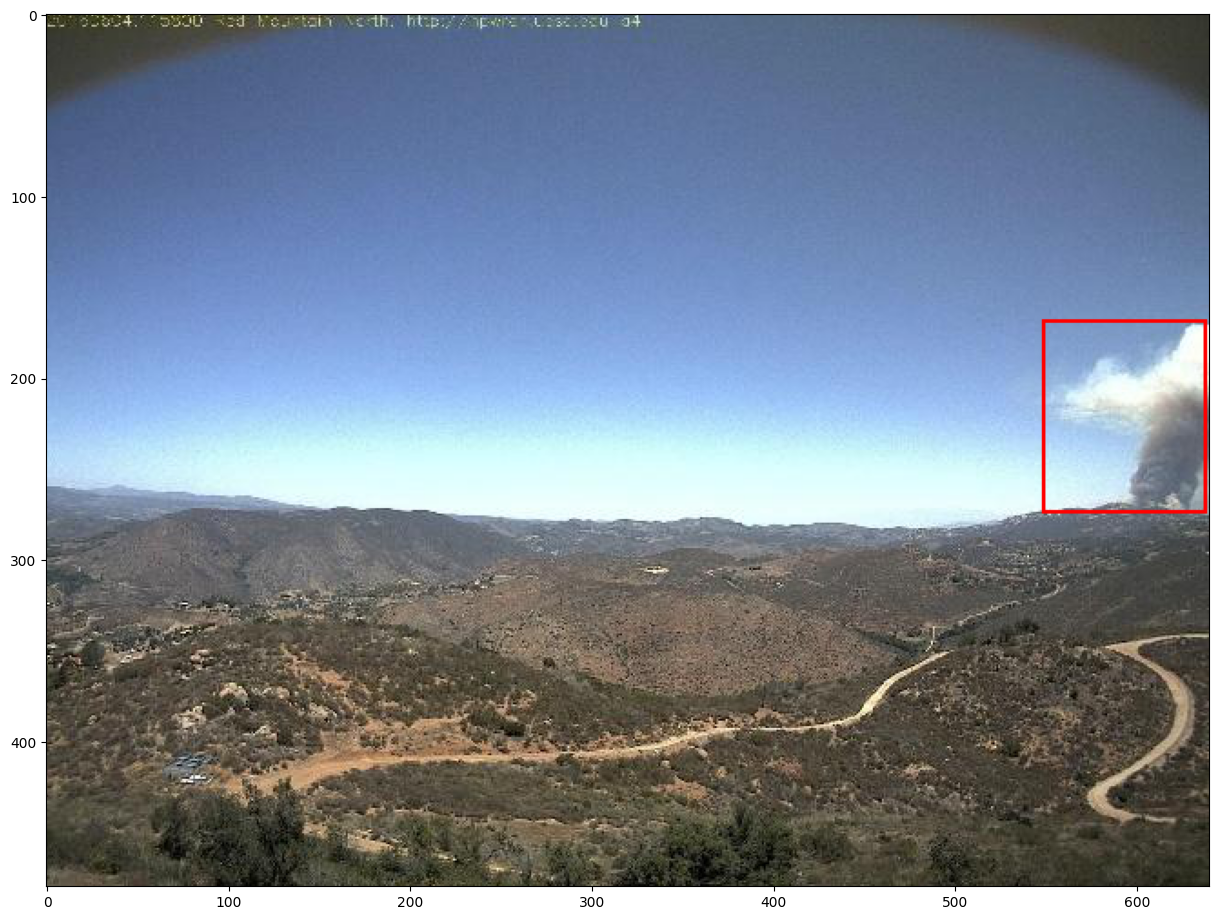

In [ ]:
filename = 'ckagz7s5solbc0841r1aklq1g_jpeg.rf.f04fe86a0d924c71ff30b51c3fc10316.jpg'
image = Image.open(f'train/{filename}')
draw = ImageDraw.Draw(image)
image_annotations = annot_collector.get_by_name(filename)
for annotation in image_annotations:
      bbox = annotation['bbox']
      draw.rectangle([(bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3])], fill=None, outline='red', width=2)
plt.figure(figsize = (15, 15))
plt.imshow(image)

## Создание модели

### Класс для работы с данными

In [ ]:
class SmokeDataset(Dataset):

  def __init__(self, path, annotations):
    self.path = path
    self.annotation_collector = CocoAnnotationCollector(annotations)

  def __getitem__(self, index):
    image_name = self.annotation_collector.image_names[index]
    annotations = self.annotation_collector.get_by_name(image_name)

    image = Image.open(f'{self.path}/{image_name}')
    image = np.array(image).transpose(2, 0, 1)
    image = image / image.max()

    t_image = torch.tensor(image, dtype=torch.float32)

    bboxes = []
    areas = []

    for annot in annotations:
      bbox = annot['bbox']
      bboxes.append([bbox[0], bbox[1],
                     bbox[0] + bbox[2], bbox[1] + bbox[3]])
      areas.append(annot['area'])

    t_bboxes = torch.tensor(bboxes, dtype=torch.float32)
    t_areas = torch.tensor(areas, dtype=torch.float32)
    t_labels = torch.ones((len(annotations),), dtype=torch.int64)
    t_iscrowd = torch.zeros((len(annotations),), dtype=torch.int64)

    target = {
        'boxes': t_bboxes,
        'area': t_areas,
        'labels': t_labels,
        'image_id': torch.tensor([index]),
        'iscrowd': t_iscrowd
    }

    return t_image, target


  def __len__(self):
    return len(self.annotation_collector.image_names)

def collate_fn(batch):
    return tuple(zip(*batch))

### Класс для сохранения модели и графиков

In [ ]:
class SaveBestModel:

    def __init__( self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save(model, 'best_model.pth')


def save_model(epochs, model, optimizer):

    print(f"Сохранение модели...")
    torch.save(model, 'final_model.pth')

def save_plots(train_loss, valid_loss):
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Эпохи')
    plt.ylabel('Ошибка')
    plt.legend()
    plt.show()
    plt.savefig('loss.png')

### Создание модели

In [ ]:
def get_model(num_classes):

  backbone = torchvision.models.squeezenet1_1(pretrained=True).features
  backbone.out_channels = 512

  anchor_generator = AnchorGenerator(
      sizes=((32, 64, 128, 256),),
      aspect_ratios=((0.5, 0.75, 1.0, 1.5, 2.0),)
  )

  roi_pooler = torchvision.ops.MultiScaleRoIAlign(
      featmap_names=['0'],
      output_size=7,
      sampling_ratio=2
  )

  model = torchvision.models.detection.FasterRCNN(
      backbone,
      num_classes=2,
      rpn_anchor_generator=anchor_generator,
      box_roi_pool=roi_pooler
  )

  return model

In [ ]:
def get_model_new(num_classes):

  backbone = torchvision.models.mobilenet_v3_small(weights='DEFAULT').features #960 / 576
  backbone.out_channels = 576

  anchor_generator = AnchorGenerator(
      sizes=((32, 64, 128, 256),),
      aspect_ratios=((0.5, 0.75, 1.0, 1.5, 2.0),)
  )

  roi_pooler = torchvision.ops.MultiScaleRoIAlign(
      featmap_names=['0'],
      output_size=7,
      sampling_ratio=2
  )

  model = torchvision.models.detection.FasterRCNN(
      backbone,
      num_classes=2,
      rpn_anchor_generator=anchor_generator,
      box_roi_pool=roi_pooler
  )

  return model

### Функции обучения

In [ ]:
def train_epoch(model, loader, optimizer):
  epoch_loss = 0

  for batch in tqdm(loader):
    images, targets = batch
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    epoch_loss += losses.detach().cpu().item()

  return epoch_loss / len(loader)


def valid_epoch(model, loader):
  epoch_loss = 0

  with torch.no_grad():
    for batch in tqdm(loader):
      images, targets = batch
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      loss_dict = model(images, targets)
      losses = sum(loss for loss in loss_dict.values())

      epoch_loss += losses.detach().cpu().item()

  return epoch_loss / len(loader)

### Инициализация модели

In [ ]:
model = get_model_new(num_classes=2)

train_dataset = SmokeDataset('train', train_annotations)
train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, shuffle = True)

valid_dataset = SmokeDataset('valid', valid_annotations)
valid_loader = DataLoader(valid_dataset, batch_size=8, collate_fn=collate_fn, shuffle = True)

optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=1e-4)

save_best_model = SaveBestModel()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
print(device)

cuda


Обучение

In [ ]:
model.train()
num_epoch = 10
train_losses = []
valid_losses = []
for e in range(num_epoch):
  train_loss = train_epoch(model, train_loader, optimizer)
  train_losses.append(train_loss)
  valid_loss = valid_epoch(model, valid_loader)
  valid_losses.append(valid_loss)
  print(f'epoch: {e + 1}, train loss: {train_loss}, valid loss: {valid_loss}')
  save_best_model(valid_loss, e, model, optimizer)

100%|██████████| 55/55 [00:12<00:00,  4.50it/s]


epoch: 1, train loss: 0.11458069959189743, valid loss: 0.056925301998853685

Best validation loss: 0.056925301998853685

Saving best model for epoch: 1



100%|██████████| 55/55 [00:12<00:00,  4.54it/s]


epoch: 2, train loss: 0.054065484437160194, valid loss: 0.052523005279627714

Best validation loss: 0.052523005279627714

Saving best model for epoch: 2



100%|██████████| 55/55 [00:12<00:00,  4.58it/s]


epoch: 3, train loss: 0.050964904842354976, valid loss: 0.05230265808376399

Best validation loss: 0.05230265808376399

Saving best model for epoch: 3



100%|██████████| 55/55 [00:11<00:00,  4.71it/s]


epoch: 4, train loss: 0.0473863962397445, valid loss: 0.05304764231497591


100%|██████████| 55/55 [00:12<00:00,  4.50it/s]


epoch: 5, train loss: 0.0455740291896897, valid loss: 0.05049194683405486

Best validation loss: 0.05049194683405486

Saving best model for epoch: 5



100%|██████████| 55/55 [00:12<00:00,  4.55it/s]


epoch: 6, train loss: 0.04194739420199767, valid loss: 0.048465230417522515

Best validation loss: 0.048465230417522515

Saving best model for epoch: 6



100%|██████████| 55/55 [00:12<00:00,  4.49it/s]


epoch: 7, train loss: 0.03840655319315071, valid loss: 0.047132055935534566

Best validation loss: 0.047132055935534566

Saving best model for epoch: 7



100%|██████████| 55/55 [00:11<00:00,  4.59it/s]


epoch: 8, train loss: 0.03678161035835122, valid loss: 0.04776965010572563


100%|██████████| 55/55 [00:11<00:00,  4.59it/s]


epoch: 9, train loss: 0.03612549838726409, valid loss: 0.048763024163517084


100%|██████████| 55/55 [00:11<00:00,  4.63it/s]

epoch: 10, train loss: 0.03543136054455923, valid loss: 0.05110107639973814


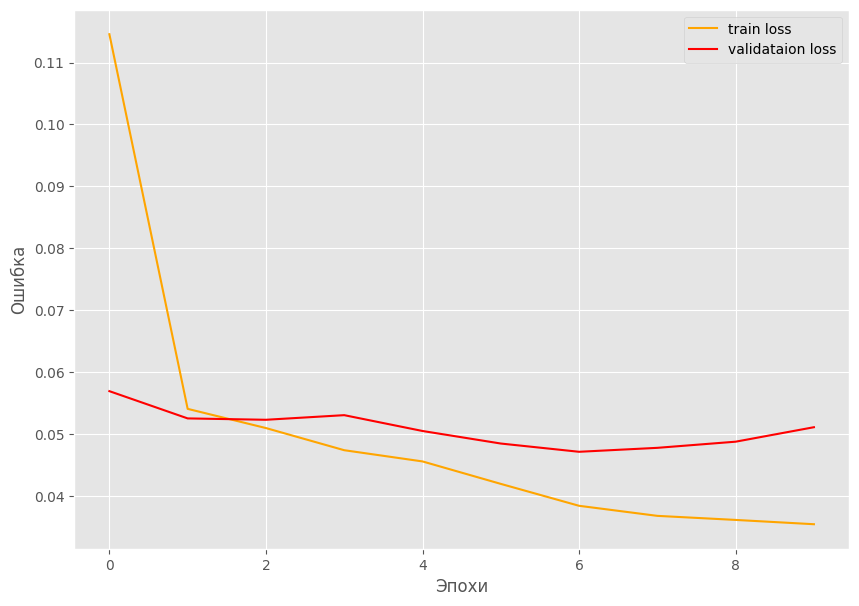

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.style.use('ggplot')
save_plots(train_losses, valid_losses)

## Предсказания модели

### Сетка изображений с разметкой

In [ ]:
model = torch.load('best_model.pth')

In [ ]:
def predict(model, annot_collector, path, index, ax=None):
  with torch.no_grad():
    image_name = annot_collector.image_names[index]
    origin_image = Image.open(f'{path}/{image_name}')
    image = np.array(origin_image).transpose(2, 0, 1)
    image = image / image.max()

    t_image = torch.tensor(image, dtype=torch.float32).to(device)
    predictions = model([t_image])[0]

    box_predictions = predictions['boxes'].detach().cpu().numpy()
    score_predictions = predictions['scores'].detach().cpu().numpy()

    top_indexes = np.where(score_predictions > 0.2)[0]

    draw = ImageDraw.Draw(origin_image)

    for i in top_indexes:
      bbox = box_predictions[i]
      draw.rectangle([(bbox[0], bbox[1]), (bbox[2], bbox[3])], fill=None, width=5, outline = 'red')

    if ax is None:
      plt.imshow(origin_image)
    else:
      ax.imshow(origin_image)


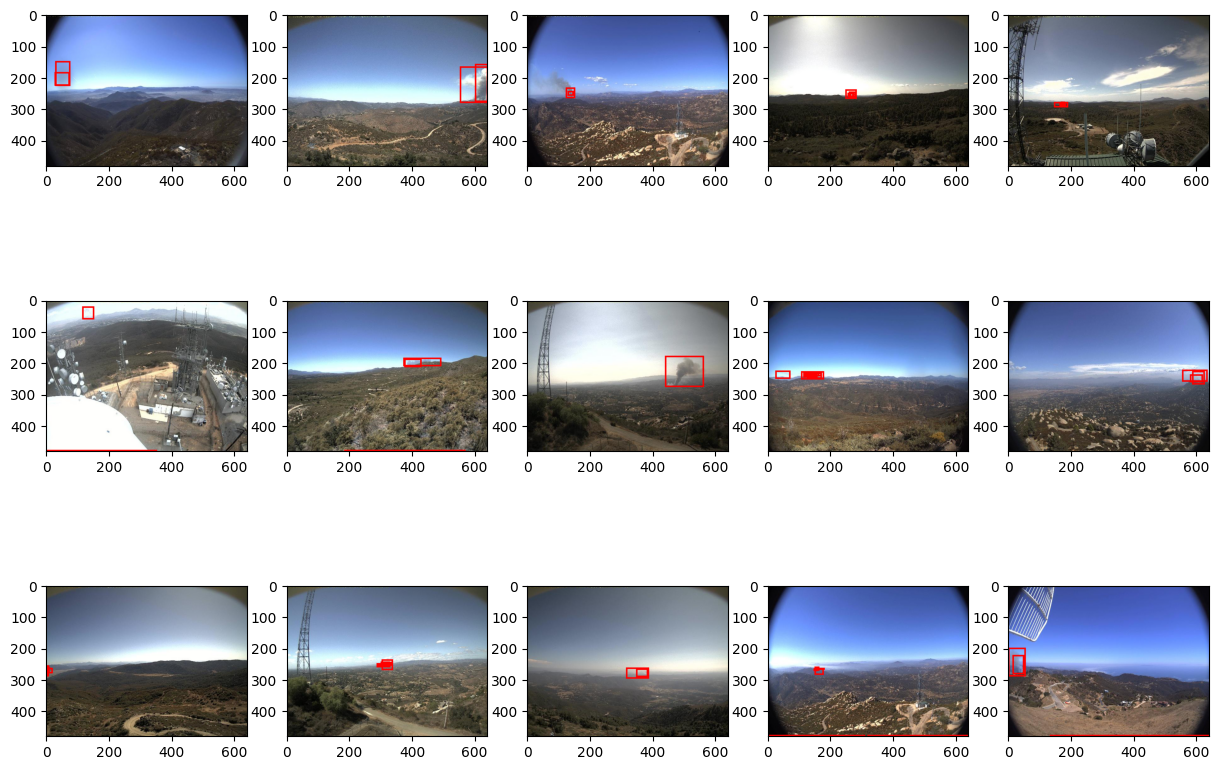

In [ ]:
model.eval()

plt.style.use('default')
N_IMAGES = 15
N_COLUMNS = 5
N_ROWS = math.ceil(N_IMAGES / N_COLUMNS)

train_annot_collector = CocoAnnotationCollector(train_annotations)
valid_annot_collector = CocoAnnotationCollector(valid_annotations)
test_annot_collector = CocoAnnotationCollector(test_annotations)

fig, axes = plt.subplots(N_ROWS, N_COLUMNS, figsize=(15, 3.5 * N_ROWS))

for pos in range(N_IMAGES):
    if N_ROWS == 1:
      ax = axes[pos]
    else:
      x_pos = pos // N_COLUMNS
      y_pos = pos % N_COLUMNS
      ax = axes[x_pos][y_pos]

    predict(model, test_annot_collector, 'test', pos+15, ax)

### Точность распознавания

In [ ]:
def predict_smoke(model, path):
    file_names = os.listdir(path)
    smoke = 0
    count = 0
    no_smoke = 0
    desired_label = 1
    with torch.no_grad():
      for file_name in file_names:
          if file_name.startswith('.'):
            continue
          image_path = os.path.join(path, file_name)
          try:
              origin_image = Image.open(image_path)
          except (OSError, UnidentifiedImageError):
              print(f"Пропуск файла {file_name} - Невозможно открыть файл.")
              continue
          image = np.array(origin_image).transpose(2, 0, 1)
          image = image / image.max()

          t_image = torch.tensor(image, dtype=torch.float32).to(device)
          predictions = model([t_image])[0]

          labels = predictions['labels'].detach().cpu().numpy()
          score_predictions = predictions['scores'].detach().cpu().numpy()

          top_indexes = 0
          top_indexes = np.where(score_predictions > 0.2)[0]

          if top_indexes.any():
            count += 1

          matching_indexes = np.where(labels == desired_label)[0]

          if len(matching_indexes) > 0:
            smoke += 1
          else:
            no_smoke += 1
    print('Изображений c верно положительным распознаванием:', smoke)
    print('Изображений c ложно отрицательным распознаванием:', no_smoke)
    print('Процент верного распознавания', (smoke / (smoke+no_smoke))*100, '%')
    print('Изображений с заданным уровнем уверенности распознавания:', count)
    print('Процент изображений с заданным уровнем уверенности распознавания: ', (count/len(file_names))*100, '%')

In [ ]:
def predict_no_smoke(model, path):
    file_names = os.listdir(path)
    smoke = 0
    count = 0
    no_smoke = 0
    desired_label = 1
    with torch.no_grad():
      for file_name in file_names:
          if file_name.startswith('.'):
            continue
          image_path = os.path.join(path, file_name)
          try:
              origin_image = Image.open(image_path)
          except (OSError, UnidentifiedImageError):
              print(f"Пропуск файла {file_name} - Невозможно открыть файл.")
              continue
          image = np.array(origin_image).transpose(2, 0, 1)
          image = image / image.max()

          t_image = torch.tensor(image, dtype=torch.float32).to(device)
          predictions = model([t_image])[0]

          labels = predictions['labels'].detach().cpu().numpy()
          score_predictions = predictions['scores'].detach().cpu().numpy()

          top_indexes = 0
          top_indexes = np.where(score_predictions > 0.2)[0]

          if top_indexes.any():
            count += 1

          matching_indexes = np.where(labels == desired_label)[0]

          if len(matching_indexes) > 0:
            smoke += 1
          else:
            no_smoke += 1
    print('Изображений с ложным распознаванием:', smoke)
    print('Изображений с правильным распознаванием:', no_smoke)
    print('Процент ошибки', (smoke / (smoke+no_smoke))*100, '%')
    print('Изображений с заданным уровнем уверенности распознавания:', count)
    print('Процент изображений с заданным уровнем уверенности распознавания: ', (count/len(file_names))*100, '%')

In [ ]:
with zipfile.ZipFile('/content/gdrive/MyDrive/Data/cloud.zip', 'r') as d:
    d.extractall('.')

In [ ]:
model.eval()
predict_smoke(model,'/content/test')
print('-'*50)
predict_no_smoke(model,'/content/cloud')

Пропуск файла _annotations.coco.json - Невозможно открыть файл.
Изображений c верно положительным распознаванием: 219
Изображений c ложно отрицательным распознаванием: 0
Процент верного распознавания 100.0 %
Изображений с заданным уровнем уверенности распознавания: 192
Процент изображений с заданным уровнем уверенности распознавания:  87.27272727272727 %
--------------------------------------------------
Изображений с ложным распознаванием: 520
Изображений с правильным распознаванием: 560
Процент ошибки 48.148148148148145 %
Изображений с заданным уровнем уверенности распознавания: 119
Процент изображений с заданным уровнем уверенности распознавания:  11.00832562442183 %
